# 1. Imports

Most of the code here was inspired from: https://www.kaggle.com/code/vencerlanz09/insect-classification-using-cnn-mobilenetv3#notebook-container

In [10]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# 2. Load and transform data

In [93]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

# 3. Placing data into Dataframe

In [94]:
# Paths to datas
train_dir = './dataset/merged/train'
valid_dir = './dataset/merged/valid'
test_dir = './dataset/merged/test'

# Lecture des fichiers _classes.csv
train_df = pd.read_csv(os.path.join(train_dir, '_classes.csv'), header=0, names=['filename', 'label'])
valid_df = pd.read_csv(os.path.join(valid_dir, '_classes.csv'), header=0, names=['filename', 'label'])
test_df = pd.read_csv(os.path.join(test_dir, '_classes.csv'), header=0, names=['filename', 'label'])

# Nettoyage des colonnes 'class'
train_df['label'] = train_df['label'].str.strip()
valid_df['label'] = valid_df['label'].str.strip()
test_df['label'] = test_df['label'].str.strip()

train_df

filename    label
0      Vespa-velutina_vespawatch_cc0_131091874_1_jpg....  present
1      Vespa-velutina_epiphane_none_169363100_2_jpg.r...  present
2      Vespa-velutina_vespawatch_cc0_138521106_0_jpg....  present
3      Vespa-velutina_kwliu_none_55559466_0_jpg.rf.18...  present
4      Vespa-velutina_vespawatch_cc0_132839989_1_jpg....  present
...                                                  ...      ...
22838  29588_jpg.rf.ffe54af19138936f0714e0b4cff647d4.jpg   absent
22839  13055_jpg.rf.ffee865fdd72a374cc0c92f9fb5c1e8c.jpg   absent
22840  73552_jpg.rf.fffdf78b99e9f82a11b6eb327494ca62.jpg   absent
22841  22867_jpg.rf.fff36328635ac89c0a4c00984d544f73.jpg   absent
22842  44065_jpg.rf.ffe9414d4aeac45bf58508779036d2ab.jpg   absent

[22843 rows x 2 columns]

# 4. Visualizing images from the dataset

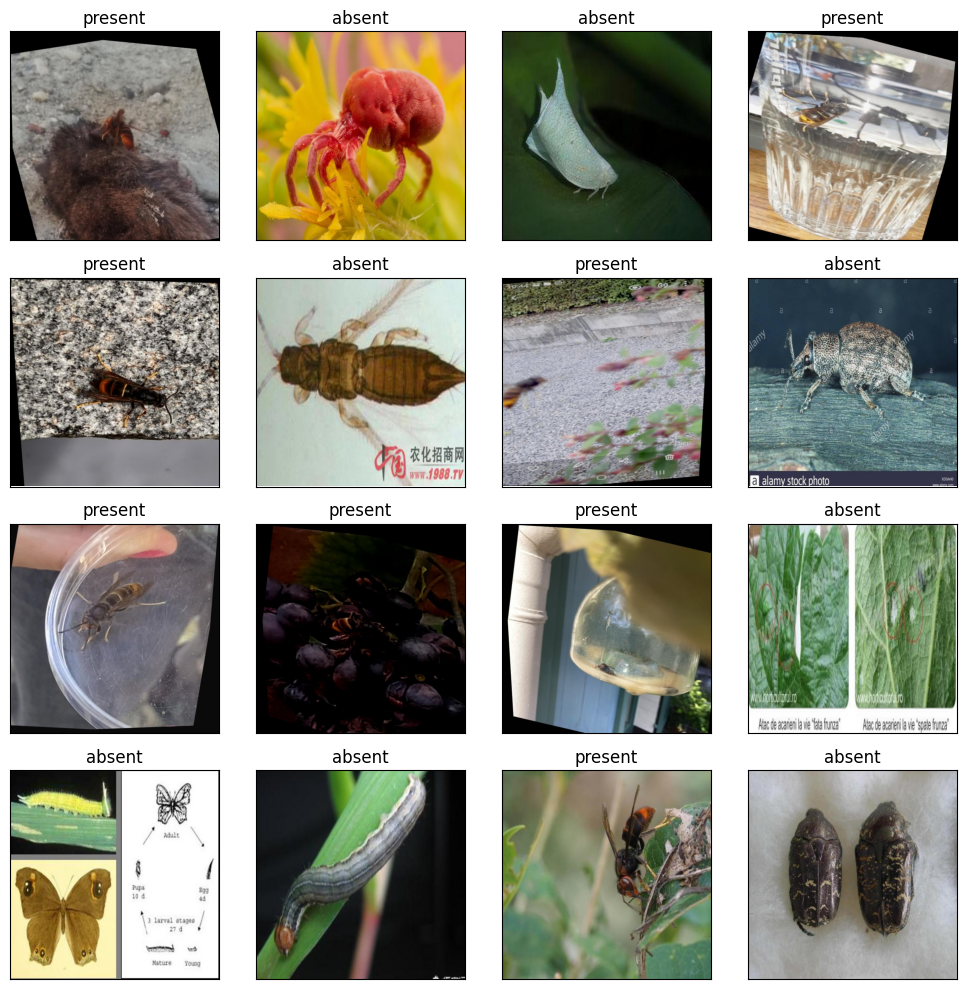

In [98]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(train_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(f'{train_dir}/{train_df.filename[random_index[i]]}'))
    ax.set_title(train_df.label[random_index[i]])
plt.tight_layout()
plt.show()

# 5. Data Preprocessing

In [99]:
train_datagen = ImageDataGenerator(rescale=0.017)
valid_datagen = ImageDataGenerator(rescale=0.017)
test_datagen = ImageDataGenerator(rescale=0.017)

In [100]:
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary',
    subset='training'
)

valid_images = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=valid_dir,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary',
)

test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)

Found 22843 validated image filenames belonging to 2 classes.
Found 3458 validated image filenames belonging to 2 classes.
Found 1719 validated image filenames belonging to 2 classes.


# 6. Training the model

In [101]:
# Load the pretrained model
pretrained_model = MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    dropout_rate=0.4,
    classifier_activation='sigmoid'
)

pretrained_model.trainable = False

In [102]:
# Create checkpoint callback
checkpoint_path = 'model_checkpoint'
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      save_best_only=True)

In [103]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss",  # watch the val loss metric
                               patience=3,
                               restore_best_weights=True)  # if val loss decreases for 3 epochs in a row, stop training

In [104]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomContrast(0.2)
], name="data_augmentation")

# 7. Train the model

In [105]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=valid_images,
    validation_steps=len(valid_images),
    epochs=100,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/100
1428/1428 [==============================] - 48s 32ms/step - loss: 0.5498 - accuracy: 0.7051 - val_loss: 0.6804 - val_accuracy: 0.5376
Epoch 2/100
1428/1428 [==============================] - 48s 34ms/step - loss: 0.4316 - accuracy: 0.7844 - val_loss: 0.6220 - val_accuracy: 0.6460
Epoch 3/100
1428/1428 [==============================] - 47s 33ms/step - loss: 0.3869 - accuracy: 0.8125 - val_loss: 0.5745 - val_accuracy: 0.7059
Epoch 4/100
1428/1428 [==============================] - 47s 33ms/step - loss: 0.3677 - accuracy: 0.8229 - val_loss: 0.5550 - val_accuracy: 0.7169
Epoch 5/100
1428/1428 [==============================] - 46s 32ms/step - loss: 0.3477 - accuracy: 0.8369 - val_loss: 0.5361 - val_accuracy: 0.7311
Epoch 6/100
1428/1428 [==============================] - 46s 32ms/step - loss: 0.3357 - accuracy: 0.8437 - val_loss: 0.5242 - val_accuracy: 0.7380
Epoch 7/100
1428/1428 [==============================] - 45s 31ms/step - loss: 0.3254 - accuracy: 0.8479 - val_loss: 0

# 8. Save trained model

In [117]:
# Sauvegarde du modèle en SavedModel
tf.saved_model.save(model, "model")

# Sauvegarde du modèle en format Keras
model.save('model_keras/vespa_velutina_binary.keras')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


# 9. Model Evaluation

In [106]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.40697
Test Accuracy: 80.98%


# 10. Visualizing loss curves

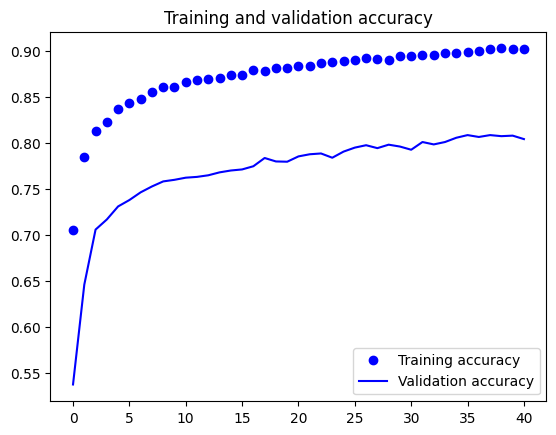

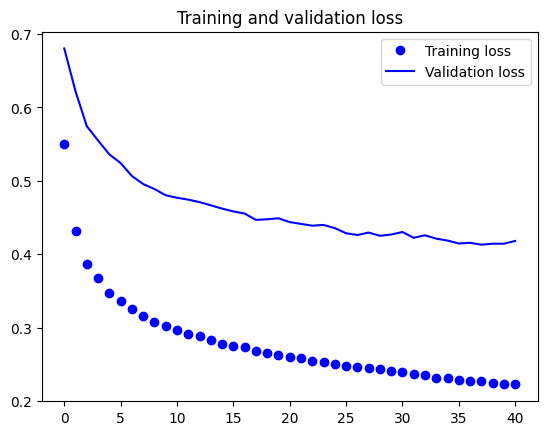

In [107]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# 11. Making predictions on the test data

In [109]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = (pred >= 0.5).astype(int).flatten()

# Map the label
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

108/108 [==============================] - 3s 29ms/step
The first 5 predictions: ['present', 'present', 'present', 'present', 'present']


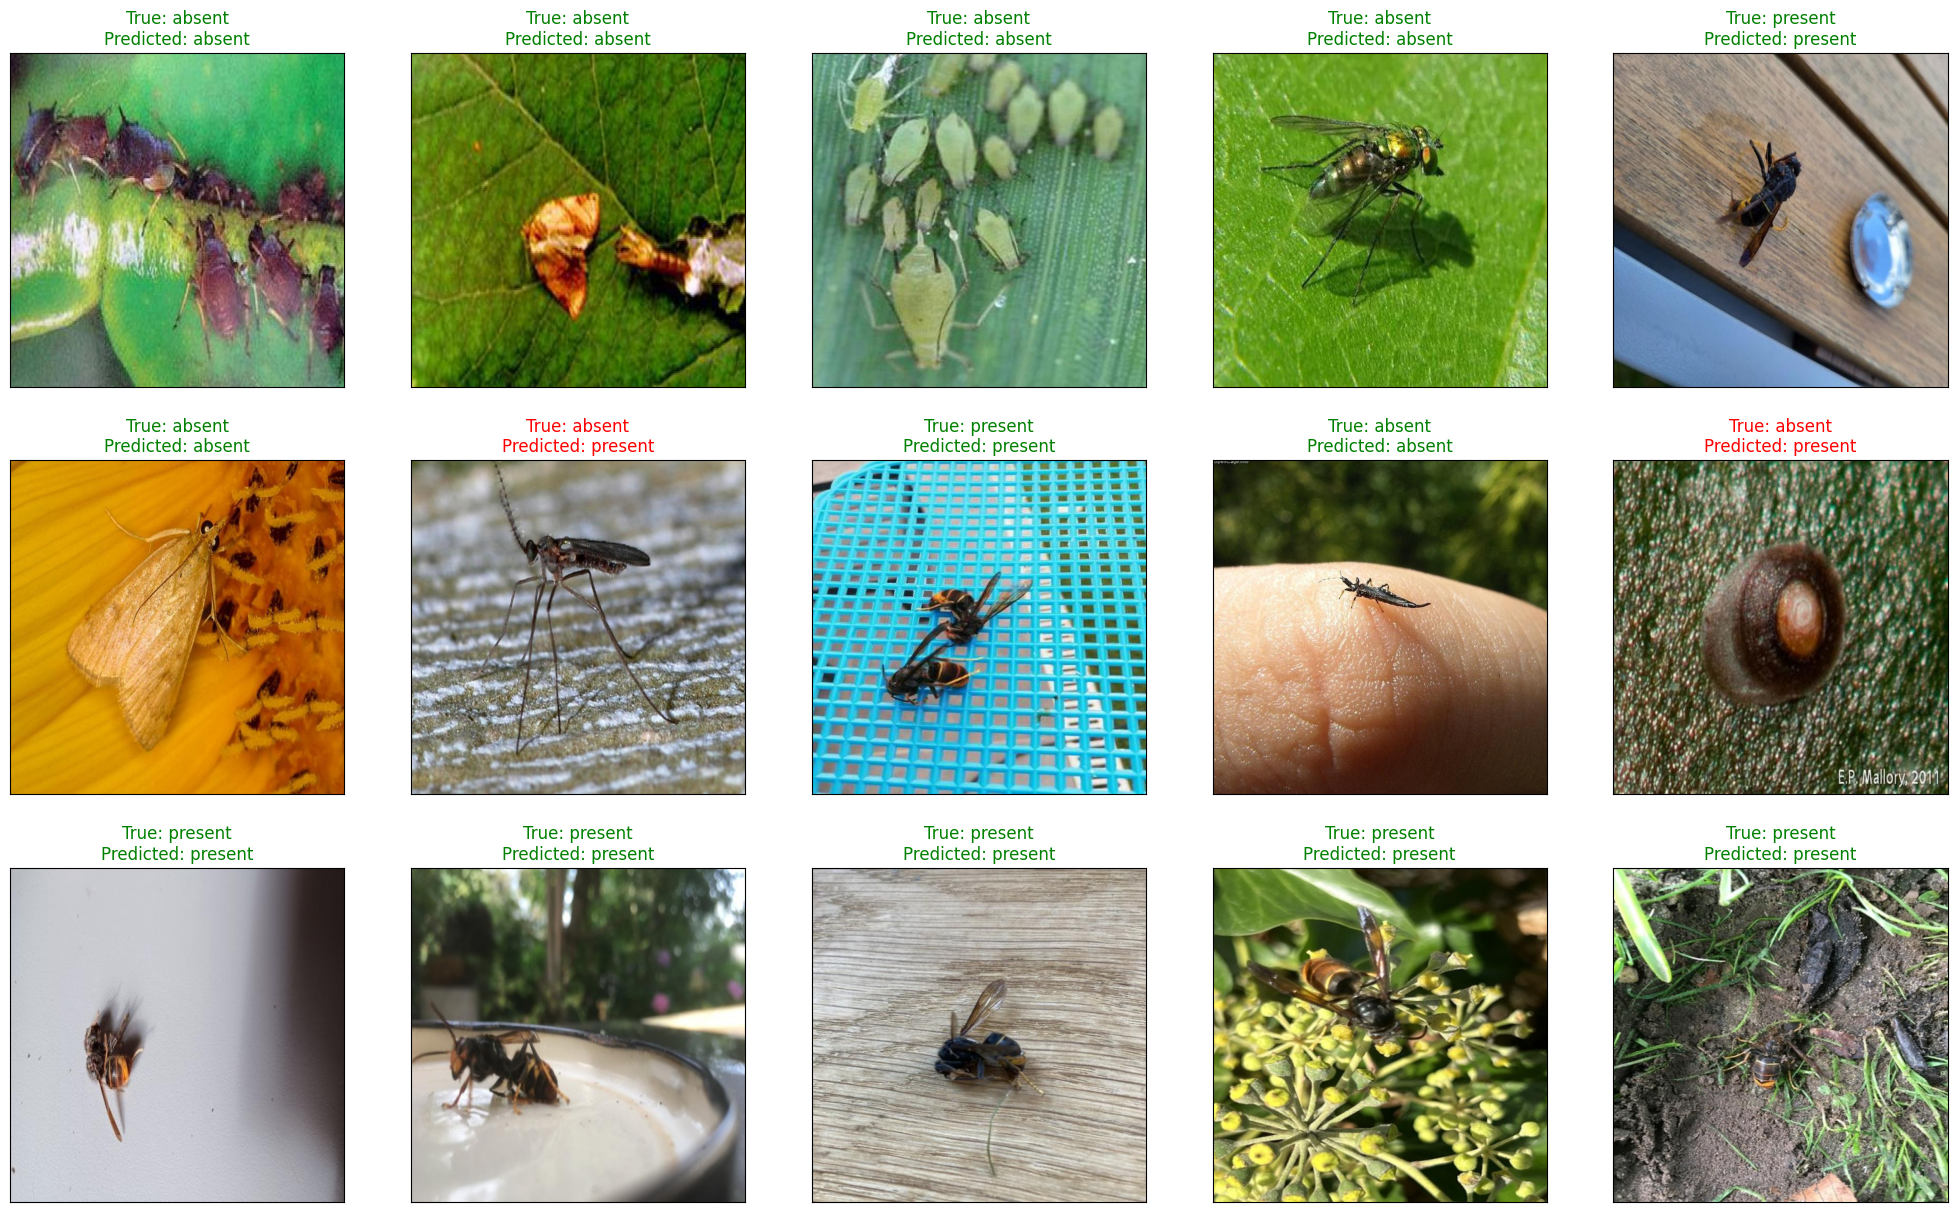

<Figure size 640x480 with 0 Axes>

In [110]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(f'{test_dir}/{test_df.filename.iloc[random_index[i]]}'))
    if test_df.label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 12. Plotting the classification reports and confusion matrix

In [111]:
y_test = list(test_df.label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      absent       0.84      0.81      0.83       954
     present       0.77      0.81      0.79       765

    accuracy                           0.81      1719
   macro avg       0.81      0.81      0.81      1719
weighted avg       0.81      0.81      0.81      1719



In [112]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
absent         0.841132  0.810273  0.825414   954.000000
present        0.773750  0.809150  0.791054   765.000000
accuracy       0.809773  0.809773  0.809773     0.809773
macro avg      0.807441  0.809711  0.808234  1719.000000
weighted avg   0.811145  0.809773  0.810123  1719.000000

In [113]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(5, 5), text_size=10, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  
    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.
  
    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).
    
    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.
  
    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,  # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

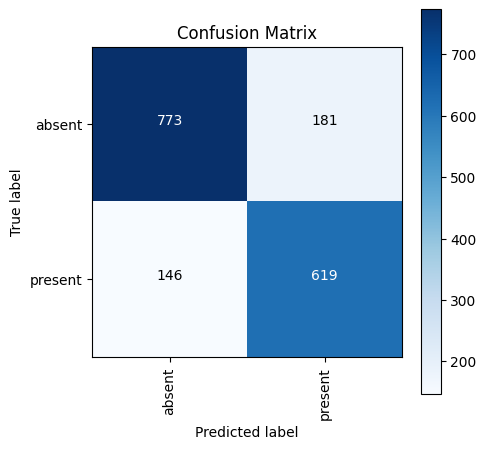

In [114]:
make_confusion_matrix(y_test, pred, list(labels.values()))

# 13. Grad-Cam Visualization

In [115]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

C:\Users\babac\AppData\Local\Temp\ipykernel_14012\2430386773.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


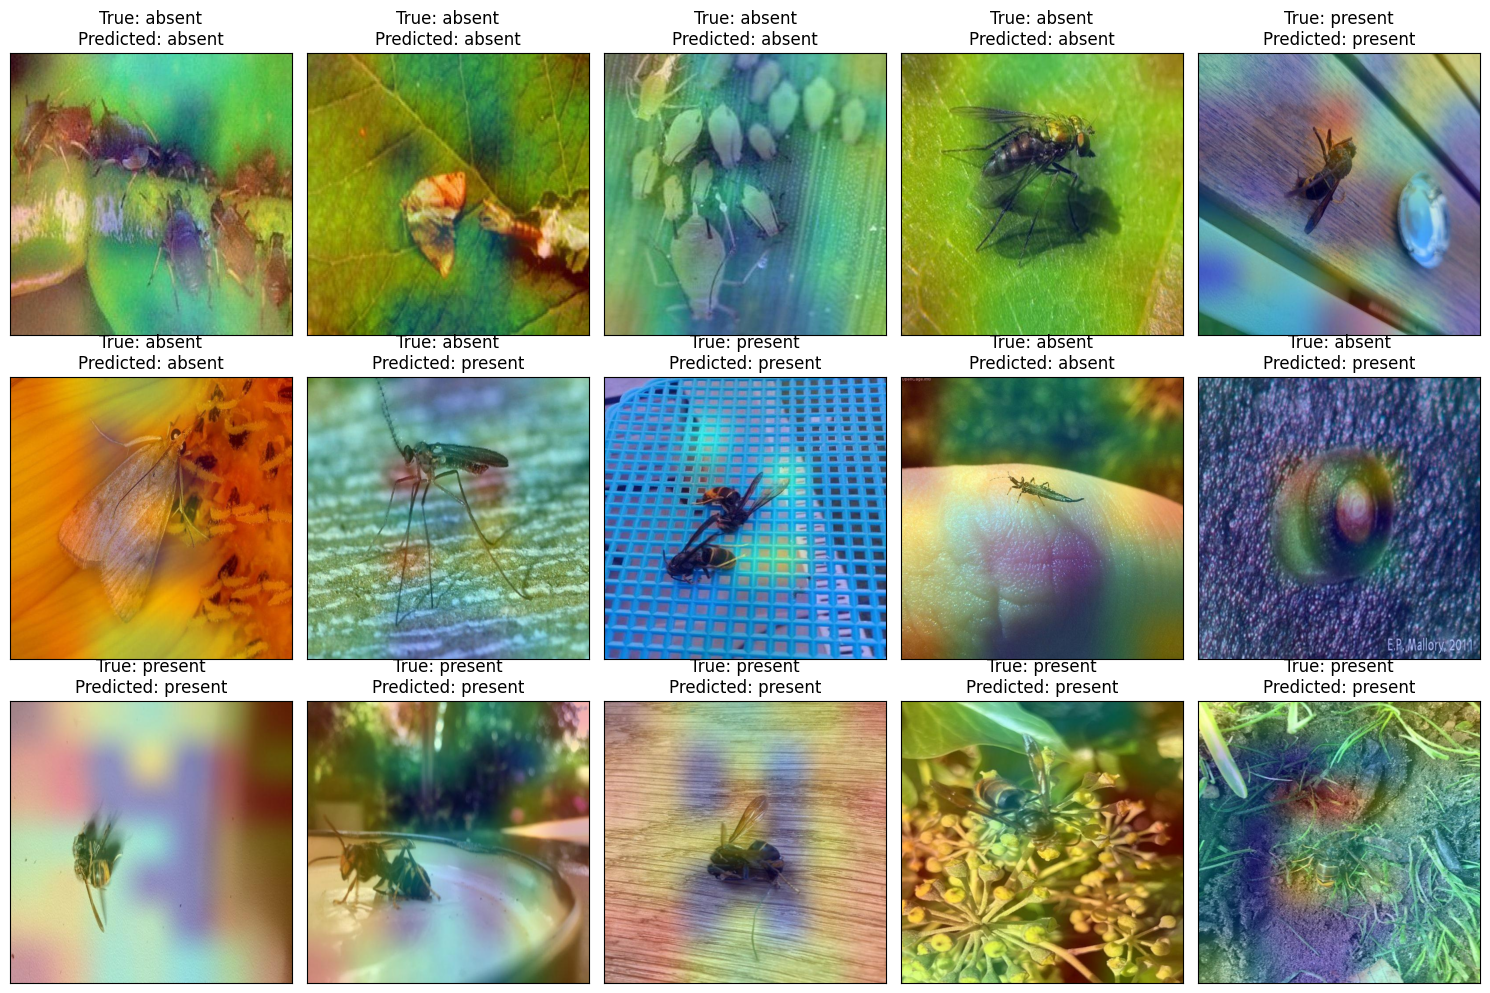

In [116]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = f'{test_dir}/{test_df.filename.iloc[random_index[i]]}'
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()